In [159]:
import os
import re
import random
import math

import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import dbscan
from matplotlib import pyplot as plt
from skimage import measure
import torch

In [160]:
# 获取数据路径
data_path = r'D:\MyCodes\RITH\puer\data_20230901\data\train'

In [161]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('use_GPU:', True)
    device = torch.device('cuda')
    torch.cuda.manual_seed_all(3407)
else:
    print('use_GPU:', False)
    device = torch.device('cpu')
    torch.manual_seed(3407)
random.seed(3407)

use_GPU: True


### 一、使用kmean聚类，初步得到标签

In [162]:
def get_label(filename):
    """使用正则表达式获取数据标签"""
    try:
        label = re.search(r'-(\d+)', filename).group(1)
        return int(label)
    except:
        print('匹配失败')
        return None

In [163]:
def kmean(data):
    """使用kmean算法使得背景图为0，杂质和茶叶为1"""
    reshaped_data = data.reshape((-1, data.shape[2]))
    # 设置聚类的簇数
    num_clusters = 2
    
    # 通过设置初始聚类中心，确保向量绝对值更大的类别被标记为0类
    initial_centers = np.array([np.mean(reshaped_data, axis=0), np.zeros(13)])

    # 创建KMeans模型并进行聚类
    kmeans = KMeans(n_clusters=num_clusters, init=initial_centers, n_init=1, random_state=0)
    # 获取聚类标签
    cluster_labels = kmeans.fit(reshaped_data).labels_
    # 获取聚类中心
    cluster_centers = kmeans.cluster_centers_
    
    # 将聚类结果重新恢复为图像的形状
    clustered_image = cluster_labels.reshape(data.shape[0], data.shape[1])
    
    # 使用连通域分析对1类的像素进行处理
    threshold = 10000
    label_image = measure.label(clustered_image, connectivity=2)
    for region in measure.regionprops(label_image):
        if region.label == 1:  # 1类的连通域
            if region.area < threshold:  # 当连通域小于阈值时，标记为0类
                clustered_image[label_image == region.label] = 0

    # 标签1的像素点转为255
    clustered_image = (clustered_image * 255 / (num_clusters - 1)).astype(np.uint8)
    
    return clustered_image


In [164]:
def get_cluster_img(filename):
    label = get_label(filename)
    
    if  label == None:
        print(label)
        return None, None, None
    
    cwl_path = os.path.join(data_path, filename, 'combined_data')
    gray_images = []
    for file in os.listdir(cwl_path):
        image = cv2.imread(os.path.join(cwl_path, file), cv2.IMREAD_GRAYSCALE)
        # plt.imshow(image)
        gray_images.append(image)
    thirteen_channel_array = cv2.merge(gray_images)
    img = kmean(thirteen_channel_array)
    
    if int(label) != 1:
        img[img==255] = 2
    else:
        img[img==255] = 1
    
    print("类别为：",label)
    plt.imshow(img)
    plt.show()
    
    return thirteen_channel_array, img, label

类别为： 0


C:\Users\GPLYMX\.conda\envs\py310\lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


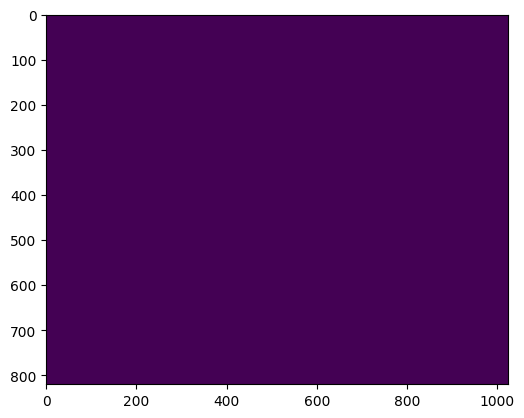

类别为： 1


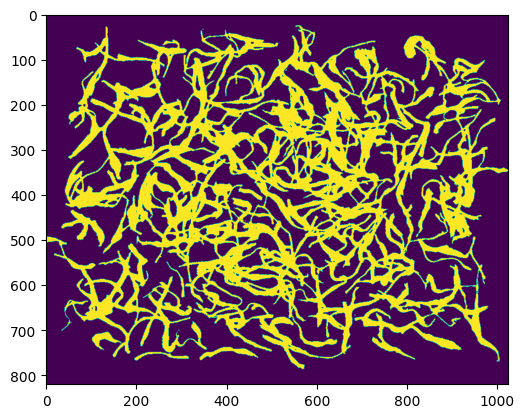

类别为： 2


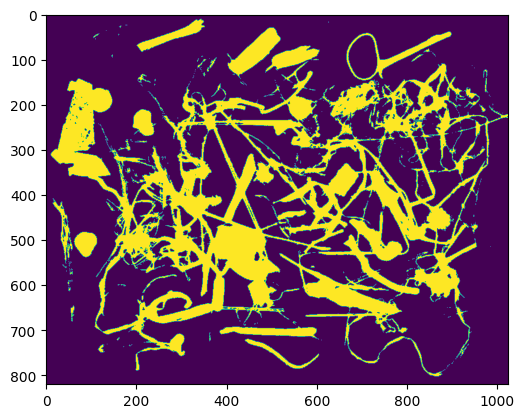

类别为： 0


C:\Users\GPLYMX\.conda\envs\py310\lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


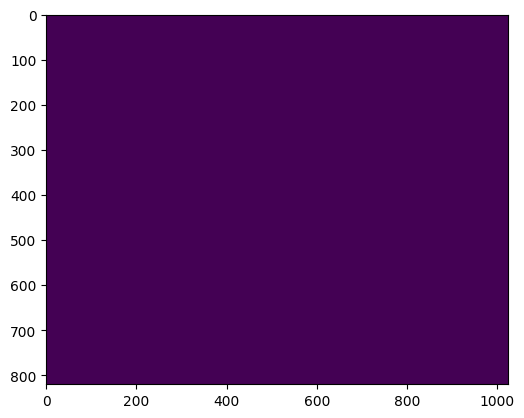

类别为： 1


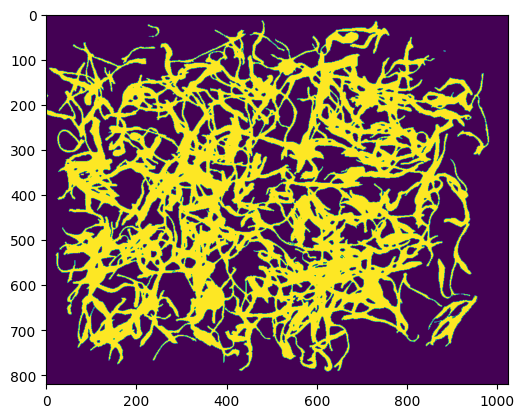

类别为： 2


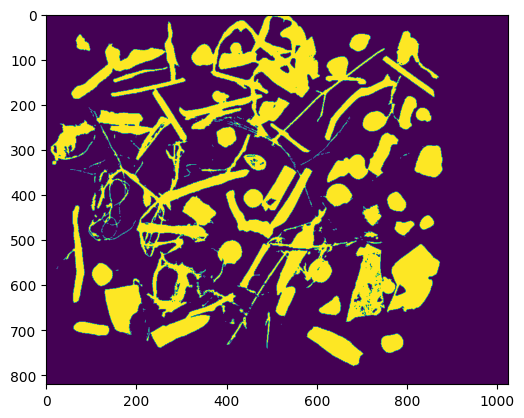

类别为： 0


C:\Users\GPLYMX\.conda\envs\py310\lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


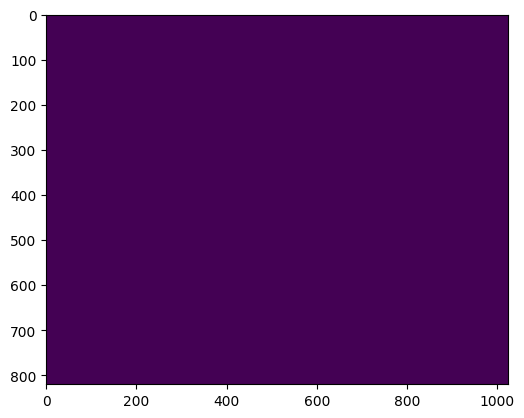

类别为： 1


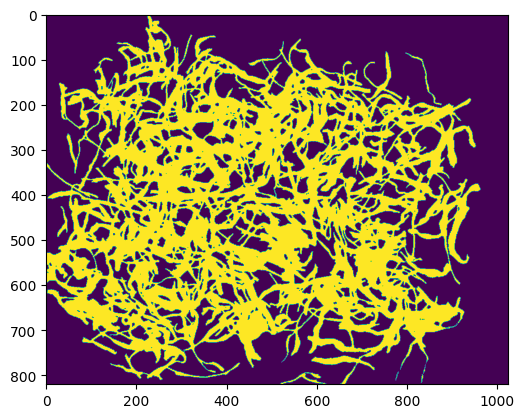

类别为： 2


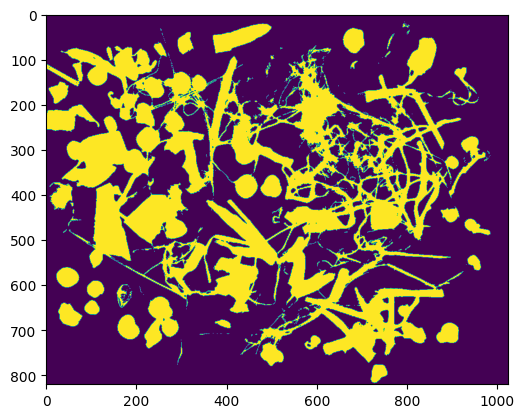

类别为： 0


C:\Users\GPLYMX\.conda\envs\py310\lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


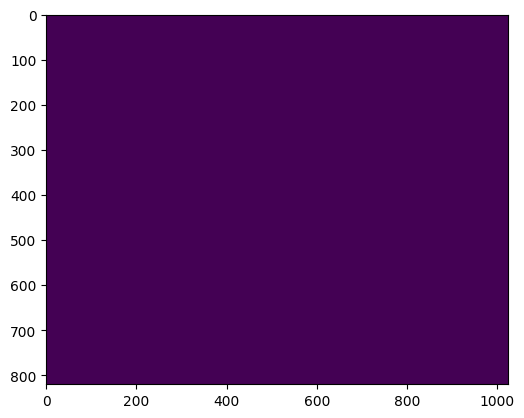

In [165]:
# 显示聚类效果
datas = []
for filename in os.listdir(data_path):
        merge_img, label_img, label = get_cluster_img(filename)
        if merge_img is None:
            continue
        datas.append([merge_img, label_img, label])

#### 按上述方法对所有图片做后处理

In [166]:
train_data = []
flag = 0
for data in datas:
    img = data[0]
    label = data[1]
    train_data.append([img, label])
random.shuffle(train_data)

### 三、使用u-net训练模型

In [167]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor, Resize
from torchvision import transforms
import torch.nn.functional as F

In [168]:
def get_size(size, base=16):
    """
    使得图片的尺寸为base的整数倍
    size为原始尺寸，格式是列表譬如[120, 300]
    输出格式为列表
    """
    base = float(base)
    rate1 = math.ceil(size[0]/base)
    rate2= math.ceil(size[1]/base) 
    return int(rate1*base), int(rate2*base)
def resize_img(img):
    """
    读取并返回修改好尺寸的图片格式是PIL
    """
    try:
        width, height = img.shape[1], img.shape[2]
        size = get_size([width, height])
        img = img.reshape([img.shape[0], size])
        return img
    except Exception as e:
        print(e)
        print('图片读取失败')

In [169]:
# 定义自定义的 Dataset 类
class CustomDataset(Dataset):
    def __init__(self, data_list, num_classes):
        self.data_list = data_list
        self.num_classes = num_classes

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        sample_image, label_image = self.data_list[idx]

        # 数据预处理逻辑
        sample_image = sample_image.transpose(2, 0, 1) / 255.0  # 归一化到 [0, 1] 范围
        print(type(sample_image))
        print(sample_image.shape)
        print(type(label_image))
        print(type(label_image))

        # 将 label_image 中的像素值映射为整数索引
        label_image = label_image.astype(np.uint8)
        
        sample_image = resize_img(sample_image)
        label_image = resize_img(label_image)

        # 创建独热编码的标签
        label_image_onehot = np.zeros((label_image.shape[0], label_image.shape[1], self.num_classes))
        for class_idx in range(self.num_classes):
            label_image_onehot[:, :, class_idx] = (label_image == class_idx)

        label_image_onehot = torch.tensor(label_image_onehot, dtype=torch.float32)  # 转换为 PyTorch 张量

        return torch.tensor(sample_image, dtype=torch.float32), label_image_onehot

In [170]:
# 定义类别数(包括背景)
num_classes = 3
in_channels = 13

# 创建自定义 Dataset 对象
custom_dataset = CustomDataset(train_data, num_classes)

# 创建 DataLoader 对象
batch_size = 1  # 设置批大小
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

In [171]:
# 基本卷积块
class Conv(nn.Module):
    def __init__(self, C_in, C_out):
        super(Conv, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(C_in, C_out, 3, 1, 1),
            nn.BatchNorm2d(C_out),
            # 防止过拟合
            nn.Dropout(0.3),
            nn.LeakyReLU(),
            nn.Conv2d(C_out, C_out, 3, 1, 1),
            nn.BatchNorm2d(C_out),
            # 防止过拟合
            nn.Dropout(0.2),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        return self.layer(x)

# 下采样模块
class DownSampling(nn.Module):
    def __init__(self, C):
        super(DownSampling, self).__init__()
        self.Down = nn.Sequential(
            # 使用卷积进行2倍的下采样，通道数不变
            nn.Conv2d(C, C, 3, 2, 1),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.Down(x)

# 上采样模块
class UpSampling(nn.Module):
    def __init__(self, C):
        super(UpSampling, self).__init__()
        # 特征图大小扩大2倍，通道数减半
        self.Up = nn.Conv2d(C, C // 2, 1, 1)

    def forward(self, x, r):
        # 使用邻近插值进行上采样
        up = F.interpolate(x, scale_factor=2, mode="nearest")
        x = self.Up(up)
        # 拼接，当前上采样的，和之前下采样过程中的
        return torch.cat((x, r), 1)

# 主干网络
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # 4次下采样
        self.C1 = Conv(in_channels, 64)
        self.D1 = DownSampling(64)
        self.C2 = Conv(64, 128)
        self.D2 = DownSampling(128)
        self.C3 = Conv(128, 256)
        self.D3 = DownSampling(256)
        self.C4 = Conv(256, 512)
        self.D4 = DownSampling(512)
        self.C5 = Conv(512, 1024)

        # 4次上采样
        self.U1 = UpSampling(1024)
        self.C6 = Conv(1024, 512)
        self.U2 = UpSampling(512)
        self.C7 = Conv(512, 256)
        self.U3 = UpSampling(256)
        self.C8 = Conv(256, 128)
        self.U4 = UpSampling(128)
        self.C9 = Conv(128, 64)

        self.Th = torch.nn.Sigmoid()
        self.pred = torch.nn.Conv2d(64, out_channels, 3, 1, 1)

    def forward(self, x):
        # 下采样部分
        R1 = self.C1(x)
        R2 = self.C2(self.D1(R1))
        R3 = self.C3(self.D2(R2))
        R4 = self.C4(self.D3(R3))
        Y1 = self.C5(self.D4(R4))

        # 上采样部分
        O1 = self.C6(self.U1(Y1, R4))
        O2 = self.C7(self.U2(O1, R3))
        O3 = self.C8(self.U3(O2, R2))
        O4 = self.C9(self.U4(O3, R1))

        # 输出预测，这里大小跟输入是一致的
        return self.Th(self.pred(O4))

### 

### 设置标志位retrain，True表示需要重新训练，False表示加载已经训练好的模型

In [172]:
retrain = True

In [173]:
if not retrain:
    model = UNet(in_channels=in_channels, out_channels=num_classes)
    model.load_state_dict(torch.load('best.mdl'))
else:
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()  
    model = UNet(in_channels=in_channels, out_channels=num_classes)  
    optimizer = optim.Adam(model.parameters(), lr=0.0001) 
    criterion = criterion.to(device)
    model = model.to(device)

    # 在训练循环中进行训练
    num_epochs = 60 
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_sample, batch_label in dataloader:
            optimizer.zero_grad()  # 梯度清零

            batch_sample = batch_sample.to(device)
            batch_label = batch_label.to(device)

            outputs = model(batch_sample)
            batch_label = batch_label.permute(0, 3, 1, 2)
            # 计算损失
            loss = criterion(outputs, batch_label.argmax(dim=1))  # 注意需要将标签从独热编码转换为索引
            total_loss += loss.item()
            # 反向传播和优化
            loss.backward()
            optimizer.step()

            # 输出损失
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss}')

<class 'numpy.ndarray'>
(13, 820, 1024)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
'tuple' object cannot be interpreted as an integer
图片读取失败
tuple index out of range
图片读取失败


AttributeError: 'NoneType' object has no attribute 'shape'

### 四、查看模型训练结果

In [144]:
def get_img(filename):
    label = get_label(filename)
    
    if not label:
        return None, None
    
    cwl_path = os.path.join(path, filename, 'pretreatment')
    gray_images = []
    for file in os.listdir(cwl_path):
        image = cv2.imread(os.path.join(cwl_path, file), cv2.IMREAD_GRAYSCALE)
        # plt.imshow(image)
        gray_images.append(image)
    ten_channel_array = cv2.merge(gray_images)
    ten_channel_array = np.array(ten_channel_array)
    ten_channel_array = torch.from_numpy(ten_channel_array)
    ten_channel_array = ten_channel_array.permute(2, 0, 1)
    ten_channel_array = ten_channel_array.unsqueeze(0)
    resize = transforms.Resize([720, 720])
    ten_channel_array = resize(ten_channel_array)
    ten_channel_array = ten_channel_array.to(torch.float32)
    ten_channel_array = ten_channel_array/255.
    
    return [ten_channel_array, label]

ten_chal_img = []
for filename in os.listdir(path):
        merge_img = get_img(filename)
        if merge_img[0] is None:
            continue
        ten_chal_img.append(merge_img)

NameError: name 'path' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


类别名： 11


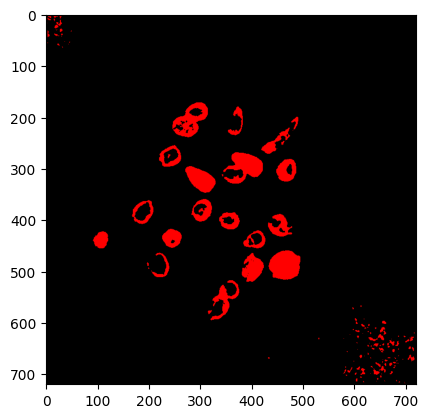

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


类别名： 11


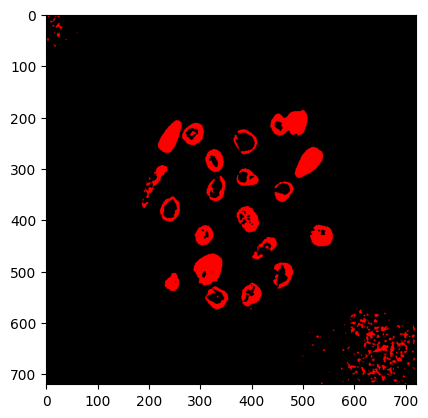

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


类别名： 12


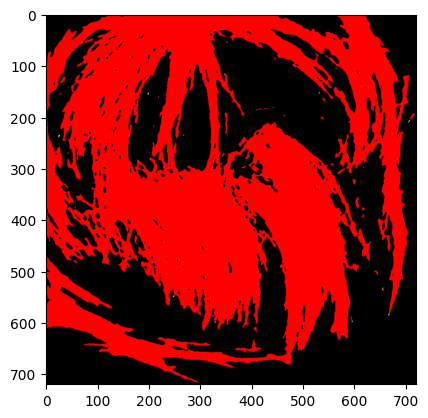

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


类别名： 13


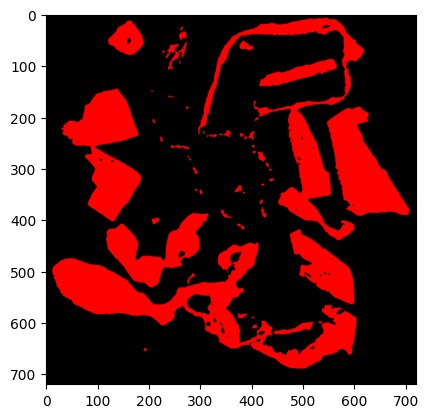

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


类别名： 14


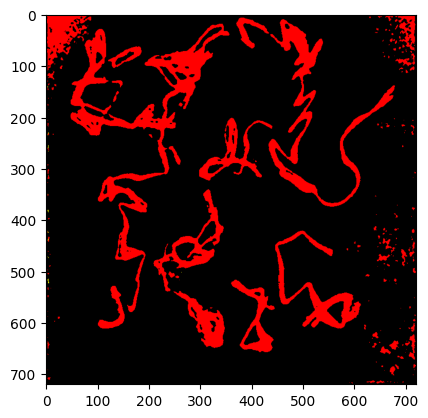

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


类别名： 14


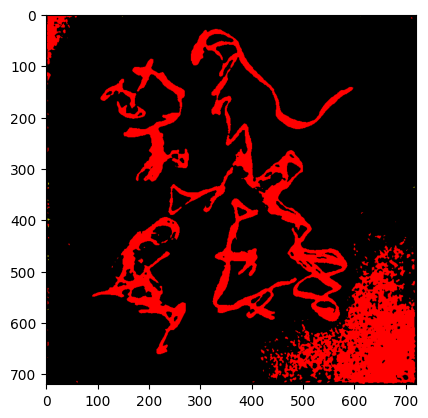

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


类别名： 15


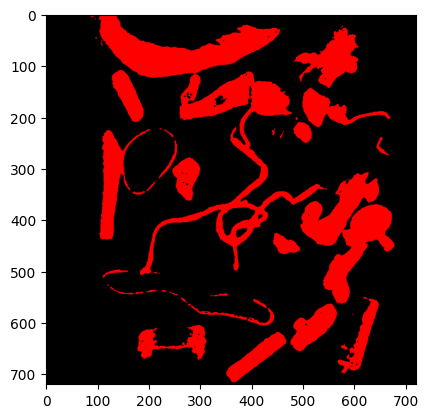

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


类别名： 1


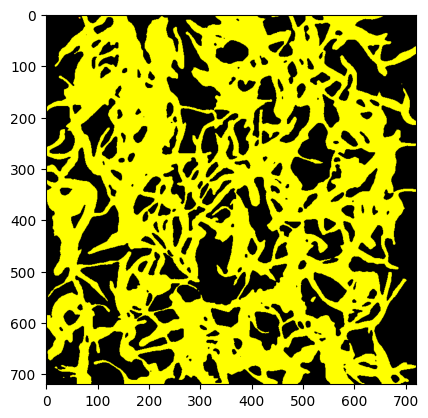

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


类别名： 2


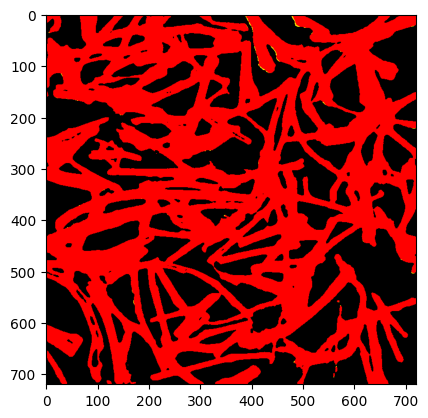

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


类别名： 3


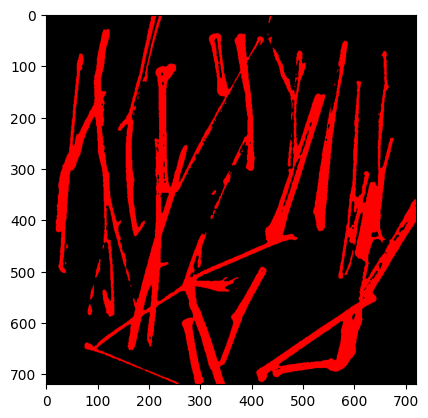

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


类别名： 4


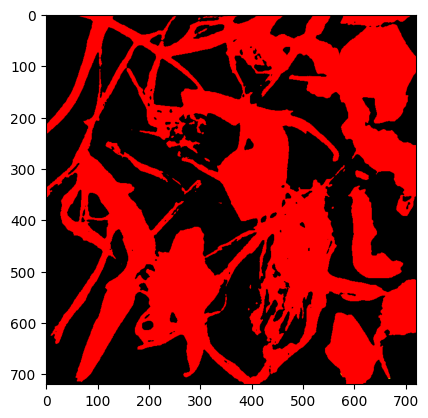

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


类别名： 5


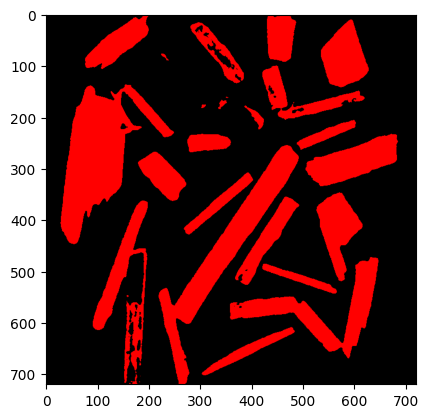

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


类别名： 6


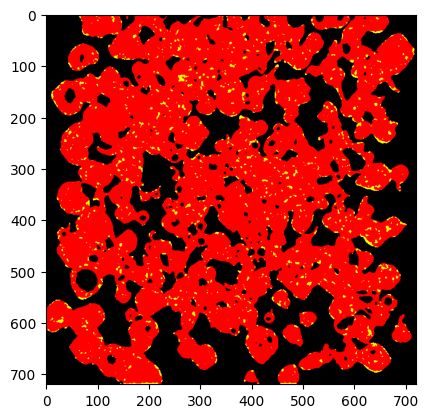

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


类别名： 7


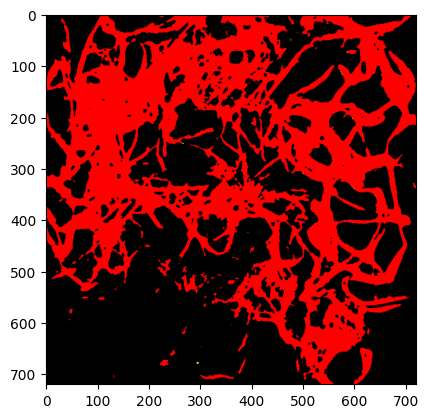

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


类别名： 8


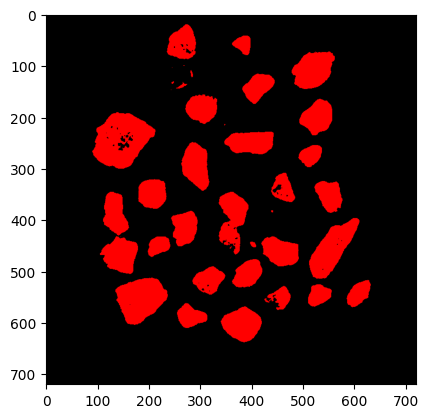

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


类别名： 9


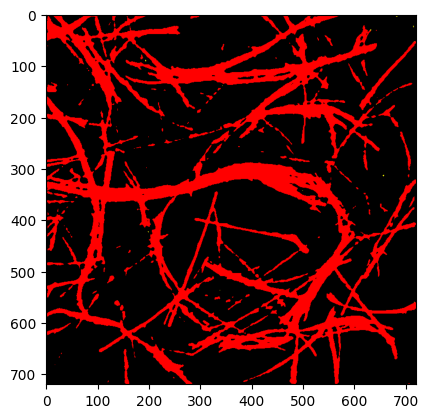

In [19]:
for img in ten_chal_img:
    model = model.to('cpu')
    image_data = model(img[0])
    image_data = image_data.squeeze(0)
    image_data = image_data.detach().numpy()
    
    max_channel_indices = np.argmax(image_data, axis=0)  # 找到每个像素最大值所在的通道索引

    # 第一个通道最大的情况，将所有值设为0
    image_data[0, max_channel_indices == 0] = 0
    image_data[1, max_channel_indices == 0] = 0
    image_data[2, max_channel_indices == 0] = 0

    # 第二个通道最大的情况，标记为黄色
    image_data[1, max_channel_indices == 1] = 255
    image_data[0, max_channel_indices == 1] = 255
    image_data[2, max_channel_indices == 1] = 0

    # 第三个通道最大的情况，标记为红色
    image_data[2, max_channel_indices == 2] = 0
    image_data[0, max_channel_indices == 2] = 255
    image_data[1, max_channel_indices == 2] = 0
    
    image_data = np.transpose(image_data, (1, 2, 0))
    print("类别名：", img[1])
    plt.imshow(image_data)
    plt.show()